# Gaia
## Real data!

gully  
Sept 14, 2016

### Outline:

1. More exploring

**Import these first-- I auto import them every time!:**

In [1]:
#! cat /Users/gully/.ipython/profile_default/startup/start.ipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import pandas as pd

In [4]:
from astropy import units as u
from astropy.coordinates import SkyCoord

### 1. Retrieve existing catalogs

Retrieve Data file from here:  
https://github.com/BrownDwarf/ApJdataFrames/blob/master/data/Luhman2012/tbl1_plusSimbad.csv

In [5]:
d1 = pd.read_csv('../../ApJdataFrames/data/Luhman2012/tbl1_plusSimbad.csv') #local version

In [6]:
d1 = d1[~d1.RA.isnull()]

In [7]:
d1.columns

Index(['Name', 'OtherNames', 'SpType', 'r_SpType', 'Adopt', '3.6mag',
       'e_3.6mag', 'f_3.6mag', '4.5mag', 'e_4.5mag', 'f_4.5mag', '5.8mag',
       'e_5.8mag', 'f_5.8mag', '8.0mag', 'e_8.0mag', 'f_8.0mag', '24mag',
       'e_24mag', 'f_24mag', 'W1mag', 'e_W1mag', 'f_W1mag', 'W2mag', 'e_W2mag',
       'f_W2mag', 'W3mag', 'e_W3mag', 'f_W3mag', 'W4mag', 'e_W4mag', 'f_W4mag',
       'Exc4.5', 'Exc8.0', 'Exc24', 'ExcW2', 'ExcW3', 'ExcW4', 'DiskType',
       'MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA',
       'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH',
       'COO_BIBCODE', 'OTYPE', 'SP_TYPE', 'SP_QUAL', 'SP_NATURE', 'SP_BIBCODE',
       'INPUT'],
      dtype='object')

In [8]:
c1 = SkyCoord(d1.RA.values, d1.DEC.values, unit=(u.hourangle, u.deg), frame='icrs')

## 2. Read in the Gaia data

In [9]:
df_list = []

This takes a finite amount of RAM, but should be fine for modern laptops.

In [10]:
for i in range(16):
    df_list.append(pd.read_csv('../data/TgasSource_000-000-{:03d}.csv'.format(i)))

In [11]:
tt = pd.concat(df_list, ignore_index=True)

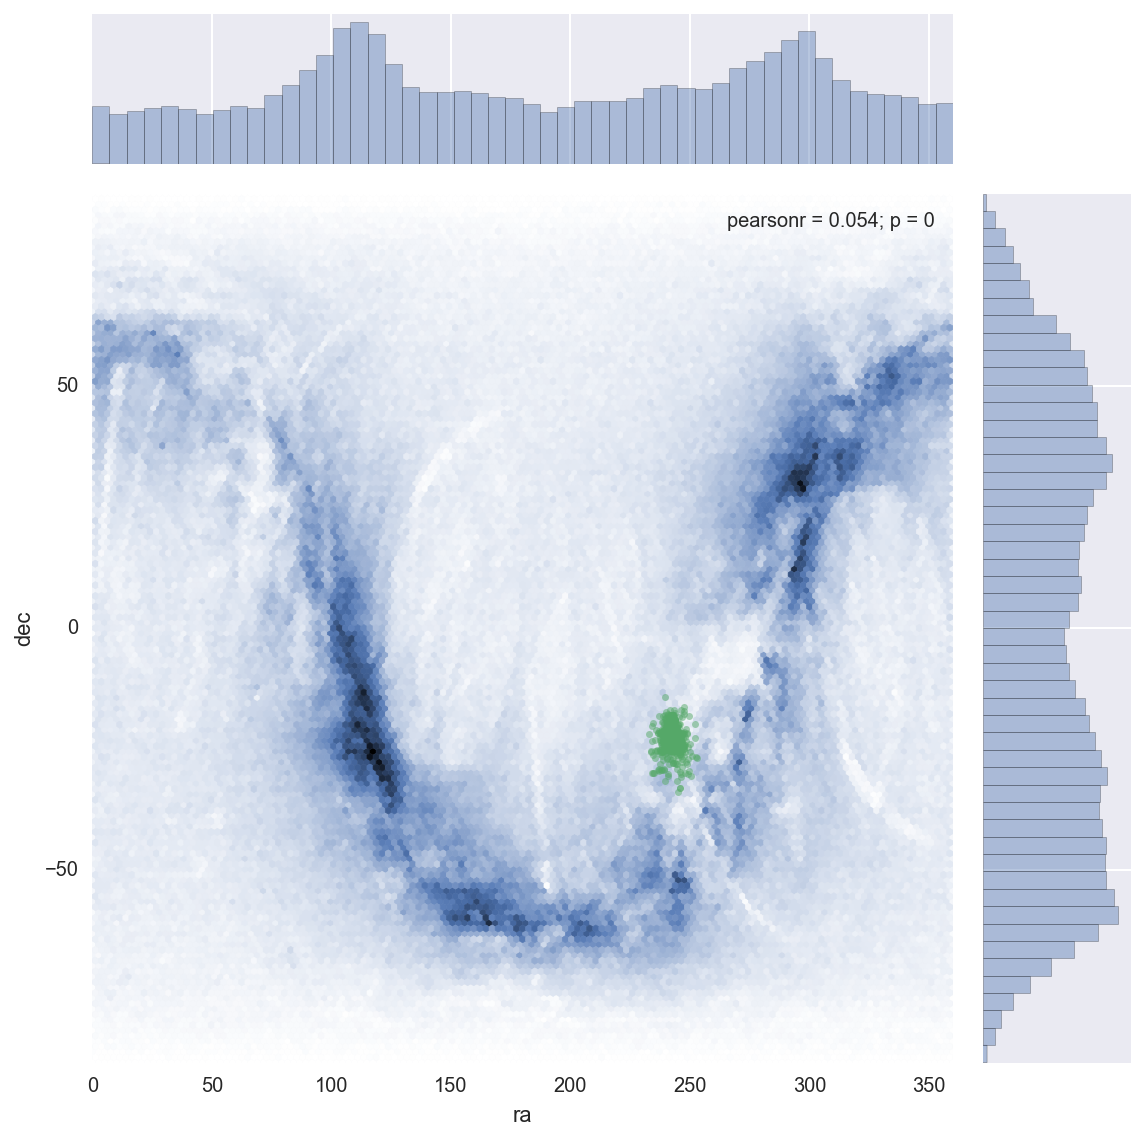

In [12]:
plt.figure(figsize=(10,4))
ax = sns.jointplot(tt.ra, tt.dec, kind='hex', size=8)
ax.ax_joint.plot(c1.ra.deg, c1.dec.deg, '.', alpha=0.5)

In [13]:
cg = SkyCoord(tt.ra.values, tt.dec.values, unit=(u.deg, u.deg), frame='icrs')

## Match

In [15]:
idx, d2d, blah = c1.match_to_catalog_sky(cg)

In [16]:
vec_units = d2d.to(u.arcsecond)
vec = vec_units.value

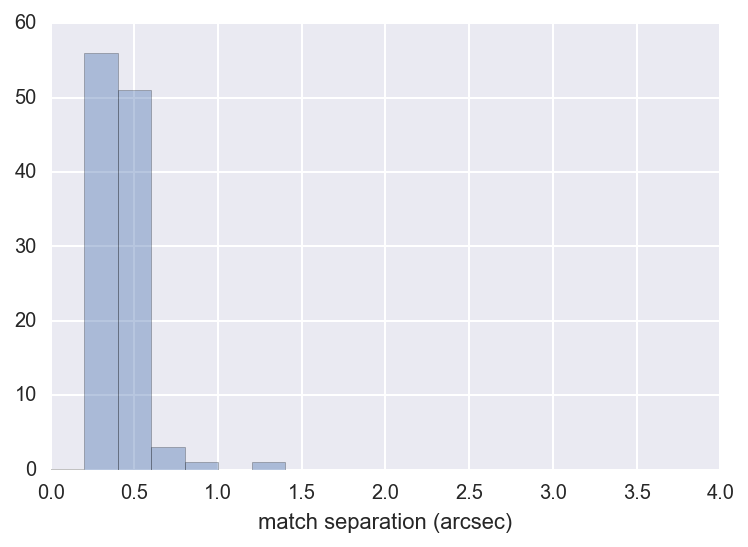

In [17]:
bins = np.arange(0, 4, 0.2)
sns.distplot(vec, bins=bins, kde=False),
plt.xlim(0,4)
plt.xlabel('match separation (arcsec)')

Forced to match to nearest neighbor

In [21]:
len(set(idx)), idx.shape[0]

(584, 862)

... yielding some redundancies in cross matching

In [22]:
tt_sub = tt.iloc[idx]
tt_sub = tt_sub.reset_index()
tt_sub = tt_sub.drop('index', axis=1)

In [23]:
d1 = d1.reset_index()
d1 = d1.drop('index', axis=1)

In [24]:
x1 = pd.concat([d1, tt_sub], axis=1)

In [25]:
x1.shape

(862, 115)

In [26]:
col_order = d1.columns.values.tolist() + tt_sub.columns.values.tolist()
x1 = x1[col_order]
x0 = x1.copy()

In [27]:
x0['xmatch_sep_as'] = vec

In [28]:
x0['Gaia_match'] = vec < 2.0 #Fairly liberal, 1.0 might be better.

//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


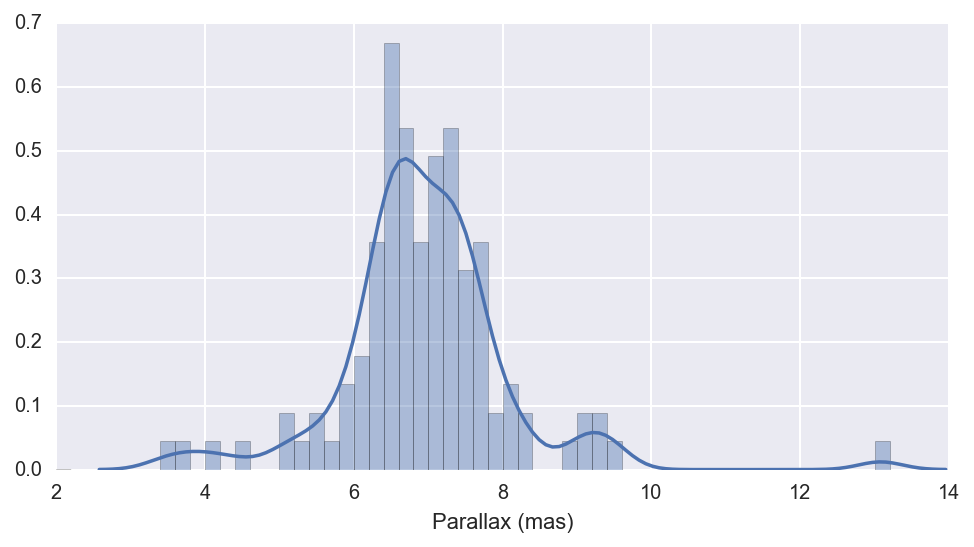

In [29]:
plt.figure(figsize=(8,4))
bins = np.arange(2, 14, 0.2)
sns.distplot(x0.parallax[x0.Gaia_match], bins=bins)
#sns.distplot(1.0/(x0.parallax[x0.Gaia_match]/1000.0))
plt.xlabel('Parallax (mas)')
plt.savefig('../results/luhman_mamajek2012.png', dpi=300)

In [32]:
x0.Gaia_match.sum(), len(d1)

(112, 862)

112 out of 862 have Gaia parallaxes... that seems high for some reason?

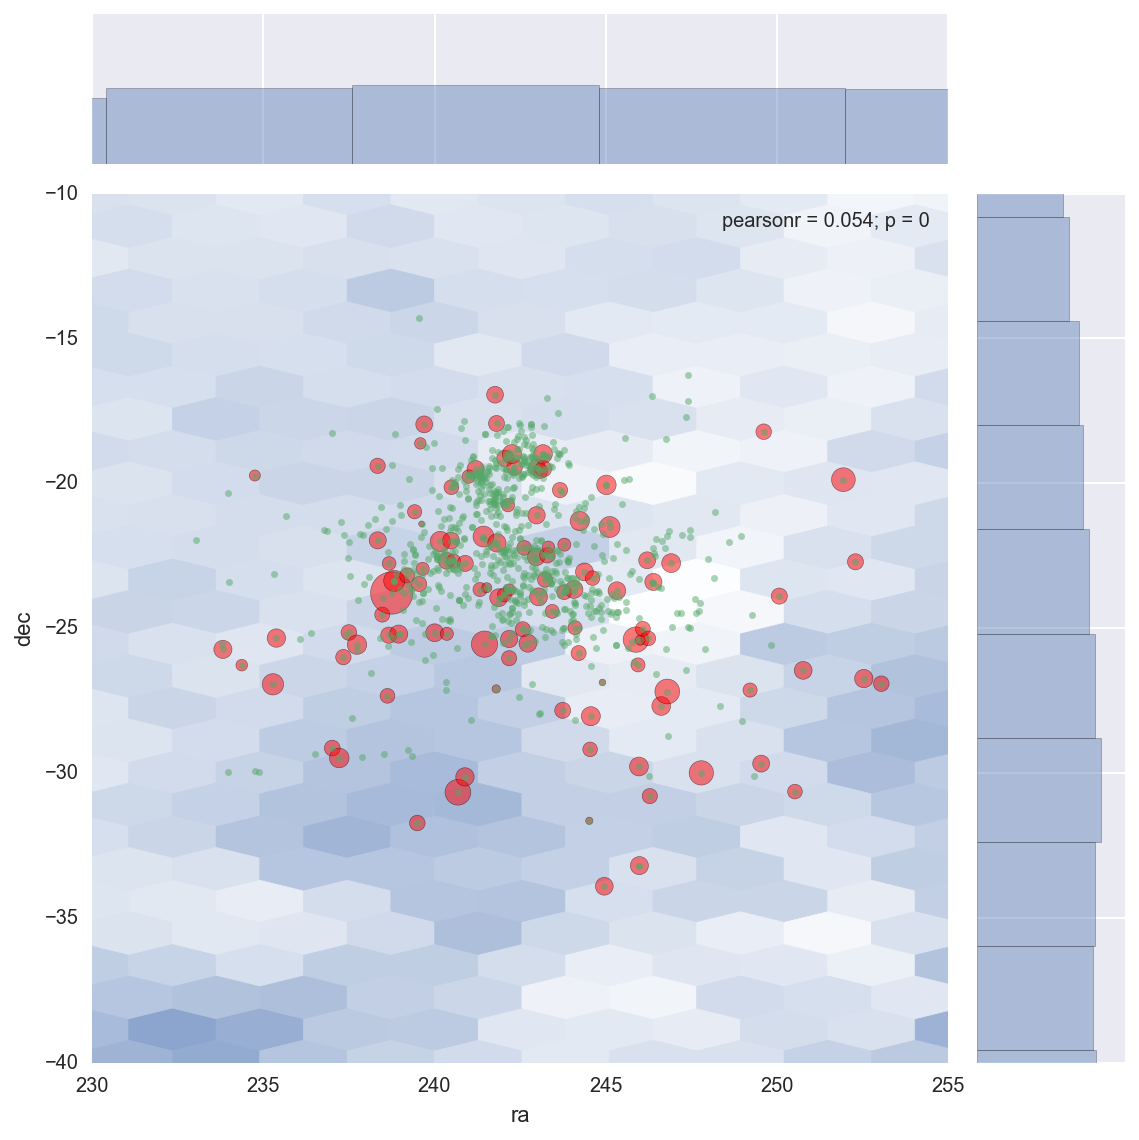

In [40]:
plt.figure(figsize=(10,4))
ax = sns.jointplot(tt.ra, tt.dec, kind='hex', size=8, xlim=(230,255), ylim=(-40,-10))
ax.ax_joint.plot(c1.ra.deg, c1.dec.deg, '.', alpha=0.5)
ax.ax_joint.scatter(x0.ra[x0.Gaia_match], x0.dec[x0.Gaia_match], 
                    s=x0.parallax[x0.Gaia_match]**3*0.2, c='r',alpha=0.5)

### The end.